Copyright 2023 Recursion

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
from efaar_benchmarking.data_loading import load_cpg16_crispr
from efaar_benchmarking.efaar import *
from efaar_benchmarking.constants import *
from efaar_benchmarking.benchmarking import univariate_consistency_benchmark, multivariate_benchmark
from efaar_benchmarking.plotting import plot_recall

recall_threshold_pairs = []
start = 0.01
end = 0.99
step = 0.01

while start <= .105 and end >= .895:
    recall_threshold_pairs.append((round(start,2), round(end,2)))
    start += step
    end -= step

print(recall_threshold_pairs)

/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/safiye.celik/.pyenv/versions/3.11.5/envs/eben/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[(0.01, 0.99), (0.02, 0.98), (0.03, 0.97), (0.04, 0.96), (0.05, 0.95), (0.06, 0.94), (0.07, 0.93), (0.08, 0.92), (0.09, 0.91), (0.1, 0.9)]


7976 perturbations exist in the map.
18565 relationships exist in the benchmark source.
58538 relationships exist in the benchmark source.
37649 relationships exist in the benchmark source.
11617 relationships exist in the benchmark source.
58059 relationships exist in the benchmark source.
18565 relationships exist in the benchmark source.
58538 relationships exist in the benchmark source.
37649 relationships exist in the benchmark source.
11617 relationships exist in the benchmark source.
58059 relationships exist in the benchmark source.
18565 relationships exist in the benchmark source.
58538 relationships exist in the benchmark source.
37649 relationships exist in the benchmark source.
11617 relationships exist in the benchmark source.
58059 relationships exist in the benchmark source.


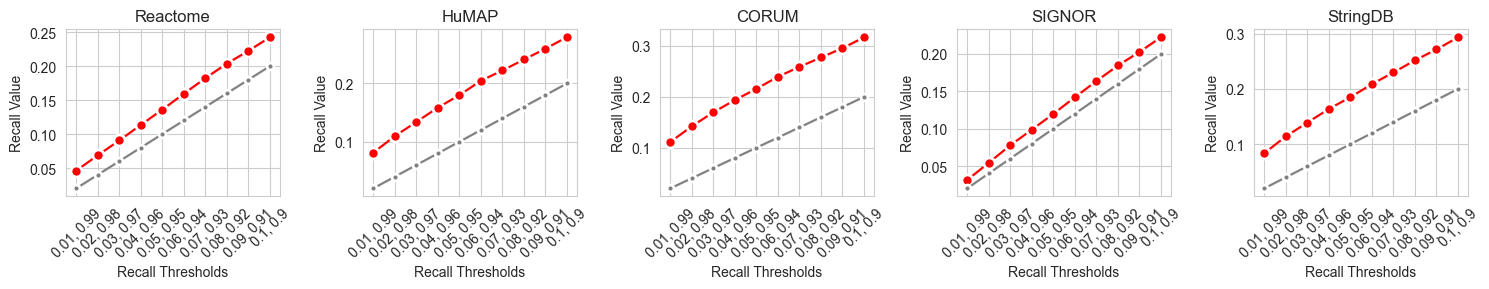

source
CORUM       0.215847
HuMAP       0.179813
Reactome    0.135907
SIGNOR      0.119795
StringDB    0.184978
Name: recall_0.05_0.95, dtype: float64

In [3]:
features, metadata = load_cpg16_crispr() # loading may take some time if the files are not cached yet, depending on the speed of your internet connection
features, metadata = filter_cell_profiler_features(features, metadata)
embeddings = embed_align_by_pca(features.values, metadata, variance_or_ncomp=.98, plate_col=JUMP_PLATE_COL)
embeddings = align_on_controls(embeddings, metadata, pert_col=JUMP_PERT_LABEL_COL, control_key=JUMP_CONTROL_PERT_LABEL)
phenoprint_pvals = univariate_consistency_benchmark(embeddings, metadata, pert_col=JUMP_PERT_LABEL_COL, keys_to_drop=[JUMP_CONTROL_PERT_LABEL, 'no-guide'])
map_data = aggregate(embeddings, metadata, pert_col=JUMP_PERT_LABEL_COL, control_key=JUMP_CONTROL_PERT_LABEL)
metrics = multivariate_benchmark(map_data, recall_thr_pairs=recall_threshold_pairs, pert_col=JUMP_PERT_LABEL_COL)
plot_recall(metrics)
metrics.groupby('source')['recall_0.05_0.95'].mean()